In [1]:
!nvidia-smi

Wed Mar 29 18:39:36 KST 2023

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:14:00.0 Off |                    0 |
| N/A   32C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32

In [2]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.25.1
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
root_dir = "230329"
data_dir = "nifti"

In [4]:
#pip install openpyxl

patient_data = pd.read_excel("patient_data.xlsx", usecols="A,B")

In [5]:
import random

train_images = sorted(glob.glob(os.path.join(data_dir, "HBP", "*.nii.gz")))
train_labels = torch.nn.functional.one_hot(torch.as_tensor(patient_data["MVI"])).float()
data_list = list(zip(train_images, train_labels))
#random.shuffle(data_list)
data_dicts = [{"image": image, "label": label} for image, label in data_list]
print(len(data_dicts))
print(data_dicts[0])

246
{'image': 'nifti/HBP/0007739.nii.gz', 'label': tensor([0., 1.])}


In [6]:
train_files, val_files = None, data_dicts[:]
target_layer=0
set_determinism(seed=0)

In [7]:
def nii_loader(filename) :
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    nimg = nib.load( filename )
    return nimg.get_fdata() , nimg.affine, nimg.header 

def visualize(dataset, idx=0, target_layer=10):
    import matplotlib.pyplot as plt    

    image = dataset[idx]['image']
    label = dataset[idx]['label']
    image_data, image_affine, image_header = nii_loader(image)
    
    print('[file path]', image)
    print('[dimension]', image_data.shape)
    print('[label]', label)
    target_image = image_data[:,:,target_layer]

    plt.imshow(target_image, cmap='gray' )
    plt.show()

[file path] nifti/HBP/0007739.nii.gz
[dimension] (96, 96, 16)
[label] tensor([0., 1.])


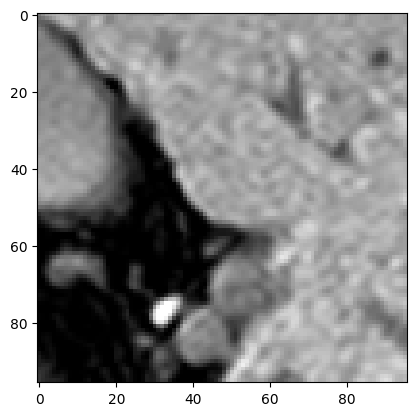

In [8]:
visualize( val_files, idx=0,  target_layer=target_layer)

In [9]:
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    AddChanneld,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandAffined,
    SpatialPadd,
    EnsureTyped,
)

In [10]:
# ScaleIntensityRanged min/max differ by organs
# for liver, min = 30 + 150/2 = 105, max = 30 - 150/2 = -45
# see more info here https://radiopaedia.org/articles/windowing-ct

from monai.transforms import Compose

train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #AddChanneld(keys=["label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-45, a_max=105,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        RandAffined(
            keys=["image"],
            mode=("bilinear"),
            prob=1.0, spatial_size=(96, 96, 16),
            rotate_range=(0, 0, 0),
            scale_range=(0, 0, 0)),
        SpatialPadd(keys=["image"], spatial_size=(96, 96, 96)),
        EnsureTyped(keys=["image"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #AddChanneld(keys=["label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-45, a_max=105,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=(96, 96, 96)),
        EnsureTyped(keys=["image"]),
    ]
)

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([])


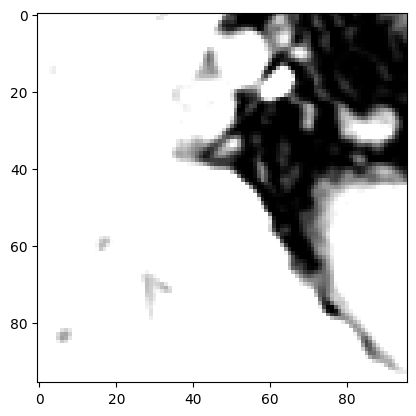

In [11]:
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

plt.imshow(image[:, :, 40], cmap="gray")
plt.show()

In [12]:
from monai.data import CacheDataset, DataLoader

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4, progress=True)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

Loading dataset: 100%|███████████████████████| 246/246 [00:01<00:00, 131.77it/s]


In [13]:
from monai.networks.nets import DenseNet121

device = torch.device("cuda:0")
model = DenseNet121(
    spatial_dims=3,
    in_channels=1,
    out_channels=2
).to(device)

In [14]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
max_epochs = 100
val_interval = 2
save_interval = 10
best_score = -1
best_score_epoch = -1
epoch_loss_values = []
metric_values = []
model_name = 'Densenet'

In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, model_name + "_model_best.pth")))
model.eval()

DenseNet121(
  (features): Sequential(
    (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
 

In [17]:
%%time

import time

tic_val = time.time()
sample_index = 0
sample_count = 0
sample_list = list()

with torch.no_grad():
    for val_data in val_loader:
        inputs, labels = val_data["image"].to(device), val_data["label"].to(device)
        outputs = model(inputs)
        sample_score = ((outputs[0][0] - outputs[0][1]) / (labels[0][0] - labels[0][1])).item()
        sample_count += 1 if sample_score > 0 else 0
        result = patient_data["patID"][sample_index], sample_score
        print(f"patID, score: {result}")
        sample_list.append(result)
        sample_index += 1
        
print(f"Accuracy: {sample_count/sample_index}")

patID, score: (7739, 8.31983757019043)
patID, score: (20491, 8.82508659362793)
patID, score: (50368, 5.867922782897949)
patID, score: (59047, 7.863114833831787)
patID, score: (63193, 7.486081123352051)
patID, score: (66509, 7.875838756561279)
patID, score: (74922, 11.16801643371582)
patID, score: (85260, 6.519686698913574)
patID, score: (85262, 4.80666971206665)
patID, score: (85263, 5.345844745635986)
patID, score: (85265, 4.163731575012207)
patID, score: (85266, 8.203858375549316)
patID, score: (85268, 6.250251770019531)
patID, score: (85269, 2.9053359031677246)
patID, score: (85287, 5.757325172424316)
patID, score: (85288, -2.746774673461914)
patID, score: (85289, 9.539634704589844)
patID, score: (85298, 4.398898124694824)
patID, score: (85299, 7.0391716957092285)
patID, score: (85300, 7.153842926025391)
patID, score: (85301, 6.091965198516846)
patID, score: (85303, 5.939398765563965)
patID, score: (85310, 9.662239074707031)
patID, score: (85313, -0.9157344102859497)
patID, score: (

In [18]:
!rm -rf pymp-*

In [19]:
sample_list.sort(key=lambda x: x[1])

In [20]:
hard_cases = pd.DataFrame(sample_list[:30], columns=['patID', 'score'])
hard_cases.to_excel("hard_cases_"+root_dir+".xlsx", index=False)

In [21]:
full_cases = pd.DataFrame(sample_list, columns=['patID', 'score'])
full_cases.to_excel("full_cases_"+root_dir+".xlsx", index=False)